In [4]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import os
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
def load_images(path):
    image_files = [file for file in os.listdir(path) if file.endswith('.png')]
    images = []
    
    for file in image_files:
        image_path = os.path.join(path, file)
        image = cv2.imread(image_path, 0)
        
        if image is not None:
            images.append(image)
    
    return images

In [6]:
images = load_images('nucleus-dataset/')
def generate_coordinates(image):
    coordinates = []
    width, height = image.shape
    for y in range(height):
        for x in range(width):
            coordinates.append((x, y, image[x][y]))

    return coordinates

coors_values = []
for image in images:
    coors_values.append(generate_coordinates(image))

In [7]:
def load_labels(path):
    data_files = [file for file in os.listdir(path) if file.endswith('_cells')]
    data = []
    for file in data_files:
        data_ins = []
        datains_path = os.path.join(path, file)
        with open(datains_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                splited = line.strip().split('\t')
                x = int(splited[0])
                y = int(splited[1])
                label = splited[2]
                data_ins.append((x,y,label))
        data.append(data_ins)
    return data

In [8]:
data_label = load_labels('nucleus-dataset/')

In [6]:
instance1 = np.array(data_label[0])
k_num = np.unique(instance1[:, 2])
k = len(k_num)
k

3

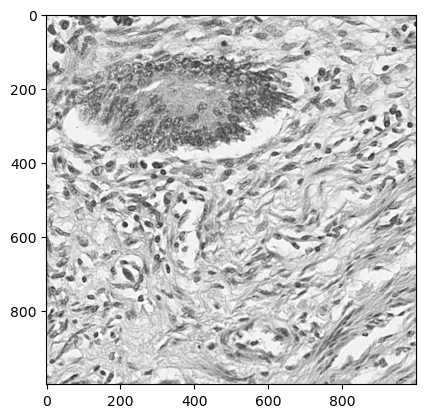

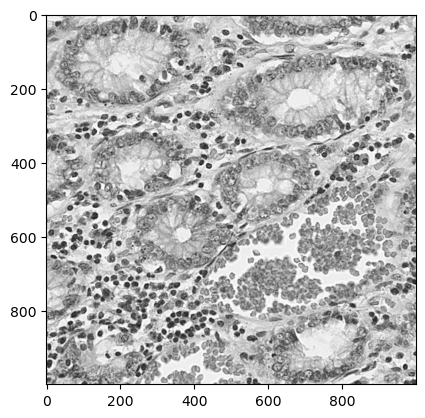

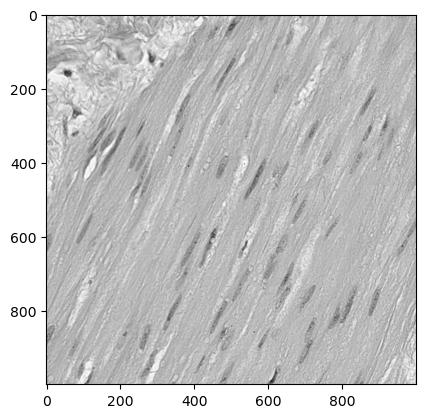

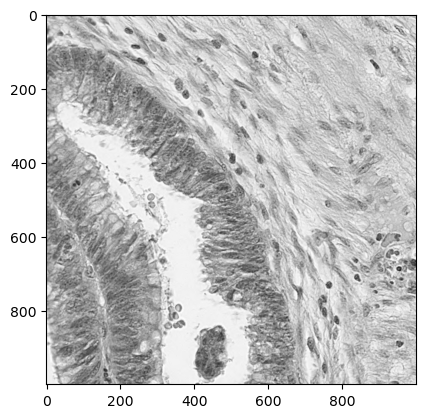

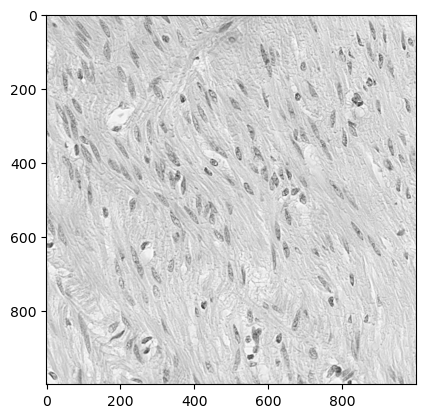

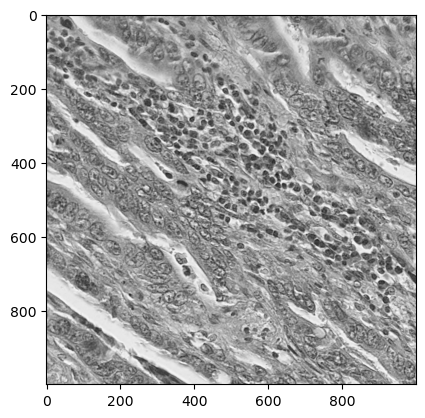

In [7]:
def plot_images(images):
    for image in images:
        plt.imshow(image, cmap='gray')
        plt.show()
        
plot_images(images)

In [8]:
def calculateCooccurrenceMatrix(patch, binNumber, di, dj):
    bin_gray_img = patch // (256 // binNumber)
    
    M = np.zeros((binNumber, binNumber), dtype=np.int64)

    for i in range(len(bin_gray_img)):
        for j in range(len(bin_gray_img[0])):
            if j + dj < len(bin_gray_img[0]) and i + di < len(bin_gray_img):
                M[bin_gray_img[i][j]][bin_gray_img[i+di][j+dj]] += 1
    
    return M

In [9]:
def calculateIntensityFeatures(patch, binNumber):
    avg = np.mean(patch)
    std = np.std(patch)
    
    hist, bins = np.histogram(patch, bins=binNumber, range=(0, 255))
    freq = hist / np.sum(hist)
    
    entropy = 0
    for i in range(len(freq)):
        if freq[i] > 0:
            entropy -= freq[i] * math.log2(freq[i])
            
    return avg, std, entropy

In [10]:
def calculateAccumulatedCooccurrenceMatrix(patch, binNumber, d):
    distances = [(d, 0), (d, d), (0, d), (-d, d), (-d, 0), (-d, -d), (0, -d), (d, -d)]
    accumlated_co_matrix = np.zeros((binNumber, binNumber))
    for di, dj in distances:
        co_occurance_matrix = calculateCooccurrenceMatrix(patch, binNumber, di, dj)
        accumlated_co_matrix += co_occurance_matrix
    return accumlated_co_matrix

In [11]:
def calculateCooccurrenceFeatures(accM):

    normM = accM / np.sum(accM)
    normM[normM == 0] = 0.00001

    asm = np.sum(np.square(normM))
    maxprob = np.max(normM)
    diff = np.abs(np.arange(normM.shape[0])[:, None] - np.arange(normM.shape[1]))
    idm = np.sum(normM / (1 + diff))
    ent = -np.sum(np.where(normM != 0, normM * np.log2(normM), 0))

    return np.array([asm, maxprob, idm, ent])

In [12]:
image1 = images[0]
row, col = image1.shape
image1.shape

(1000, 1000)

In [13]:
def crop_patches(image, window_size):
    cropped_patches = []
    coordinates = []
    row, col = image.shape[:2]
    for y in range(window_size // 2, row - window_size // 2):
        for x in range(window_size // 2, col - window_size // 2):
            patch = image[y - window_size // 2: y + window_size // 2, x - window_size // 2: x + window_size // 2]
            cropped_patches.append(patch)
            coordinates.append((y,x))

    return np.array(cropped_patches), np.array(coordinates)

In [14]:
a, b = crop_patches(image1, 4)
a.shape, b.shape

((992016, 4, 4), (992016, 2))

In [15]:
def get_features_coordinates(binNumber, d, pacthnum):
    image_features = []
    coors = []
    for image in images:
        patches, coordinates = crop_patches(image, pacthnum)
        #binNumber = 2
        #d = 1
        concatenated_featues = []
        for patch in patches:
            intensityFeatures = calculateIntensityFeatures(patch, binNumber)
            accM = calculateAccumulatedCooccurrenceMatrix(patch, binNumber, d)
            texturalFeat = calculateCooccurrenceFeatures(accM)
            concat_features = np.concatenate((intensityFeatures, texturalFeat))
            concatenated_featues.append(concat_features)
        image_features.append(concatenated_featues)
        coors.append(coordinates)
    return np.array(image_features), np.array(coors)

In [16]:
features, coordinates = get_features_coordinates(2, 1, 4)

In [17]:
features.shape, coordinates.shape

((6, 992016, 7), (6, 992016, 2))

In [18]:
def cluster(image_features, coornidates, k):
    #image_features1 = np.array(image_features)
    #coors1 = np.array(coors)
    #image_features1[0][0],coors1[0][0]
    image_features_data = image_features.reshape((image_features.shape[0] * image_features.shape[1],-1))
    image_features_data.shape, image_features.shape
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(image_features_data)
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(normalized_features)
    labels = kmeans.labels_
    return labels

In [19]:
labels1 = cluster(features, coordinates, k)
labels1.shape

C:\Users\aydin\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(5952096,)

In [20]:
def get_results(k_labels, coordinates, images):
    k_labels = k_labels.reshape(6, -1, 1)

    third_array = np.zeros((k_labels.shape[0], k_labels.shape[1], 3))

    for image in range(coordinates.shape[0]):
        for coords_ in range(coordinates.shape[1]):
            label = k_labels[image, coords_, 0]
            x = coordinates[image, coords_, 0]
            y = coordinates[image, coords_, 1]
            third_array[image, coords_] = [x, y, label]
    image_p = np.zeros((6, 1000, 1000))
    
    for i in range(6):
        for j in range(third_array.shape[1]):
            x = int(third_array[i, j, 0])
            y = int(third_array[i, j, 1])
            label = int(third_array[i, j, 2])
            label = label + 1
            image_p[i,x, y] = label
            
    return image_p

In [21]:
image_p = get_results(labels1, coordinates, images)

In [22]:
def plot_image(image):
    cmap = plt.cm.get_cmap('tab10', int(np.max(image)) + 1)

    plt.imshow(image, cmap=cmap, vmin=0, vmax=np.max(image))

    plt.colorbar()

    plt.show()

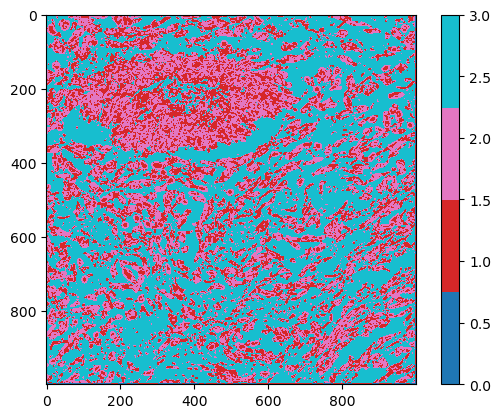

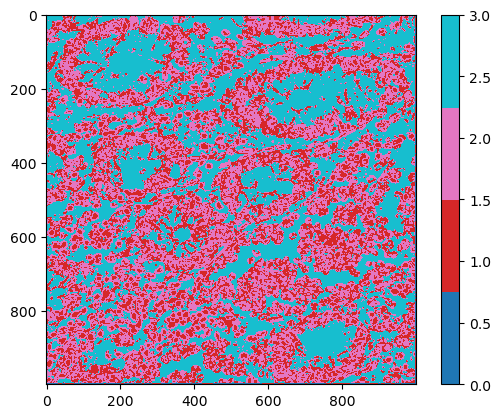

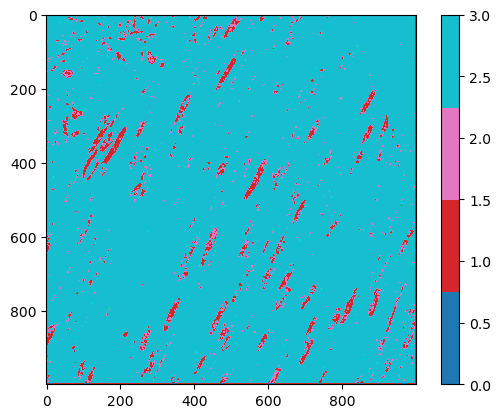

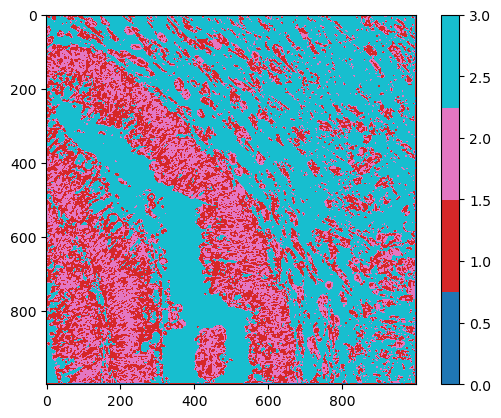

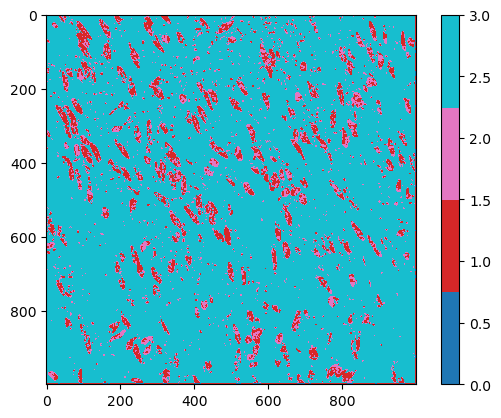

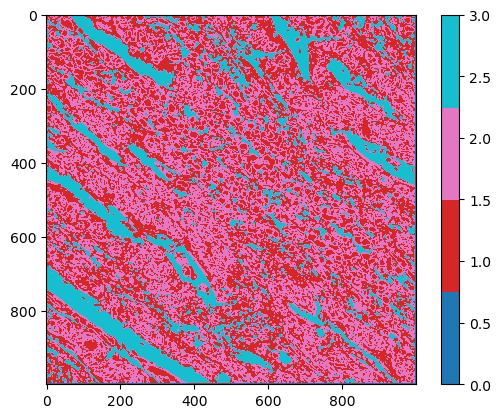

In [23]:
for image in image_p:
    plot_image(image)

In [24]:
labels2 = cluster(features, coordinates, k=5)
labels2.shape

C:\Users\aydin\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(5952096,)

In [25]:
image_p5 = get_results(labels2, coordinates, images)

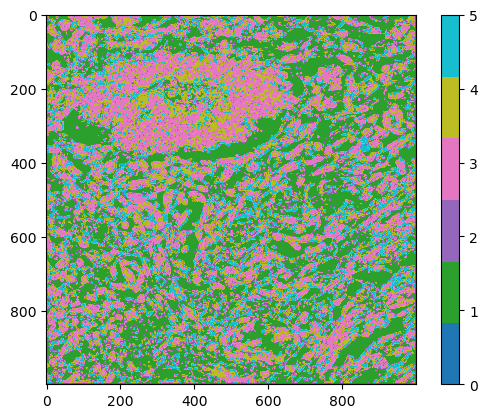

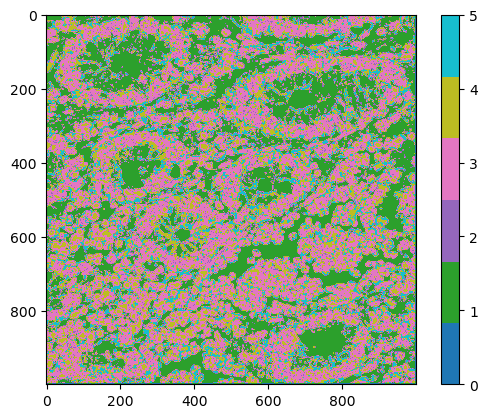

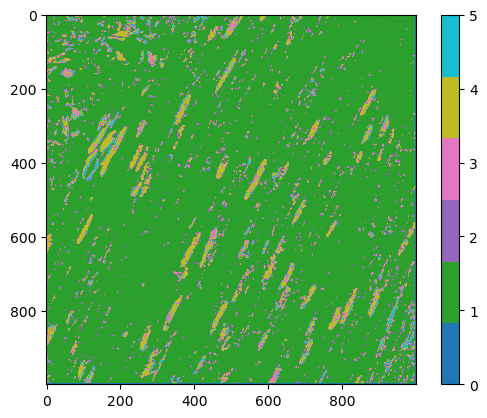

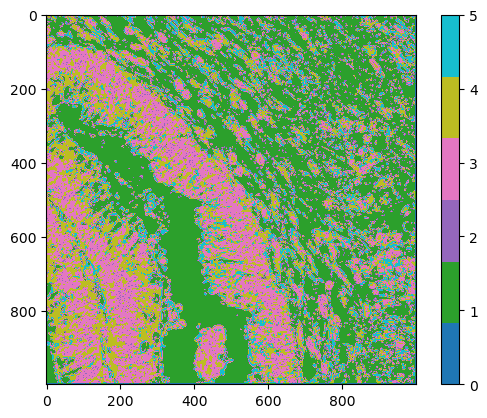

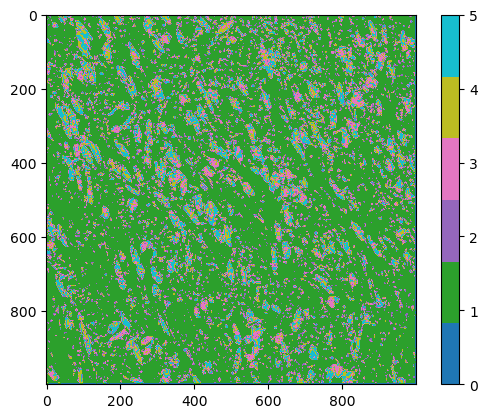

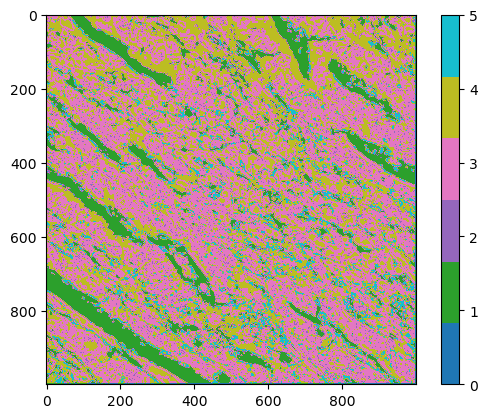

In [26]:
for image in image_p5:
    plot_image(image)

In [27]:
features3, coordinates3 = get_features_coordinates(4, 2, 8)

In [28]:
labels3 = cluster(features3, coordinates3, k)
labels3.shape

C:\Users\aydin\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(5904384,)

In [29]:
image_p3 = get_results(labels3, coordinates3, images)

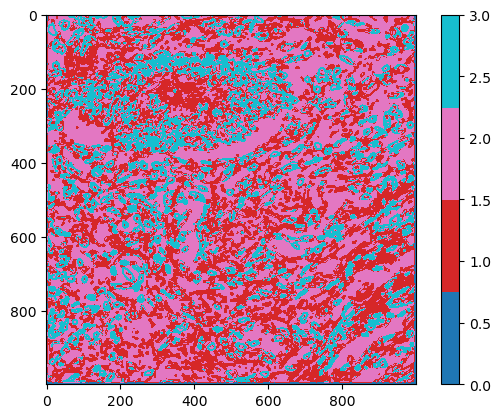

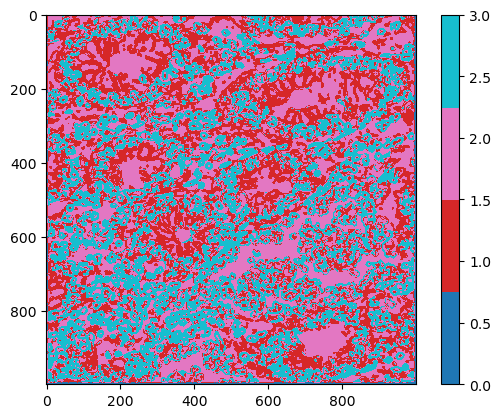

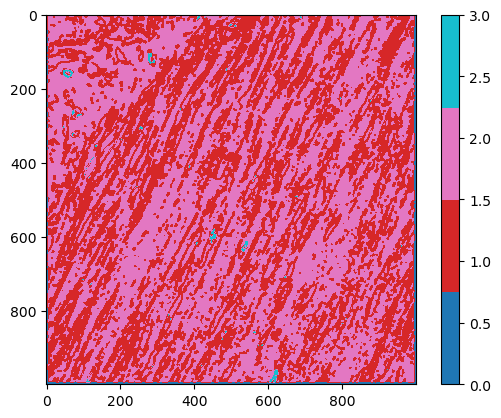

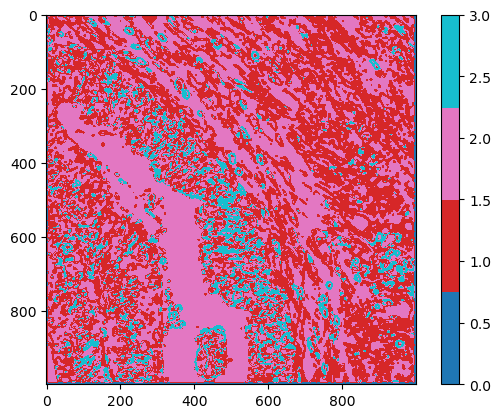

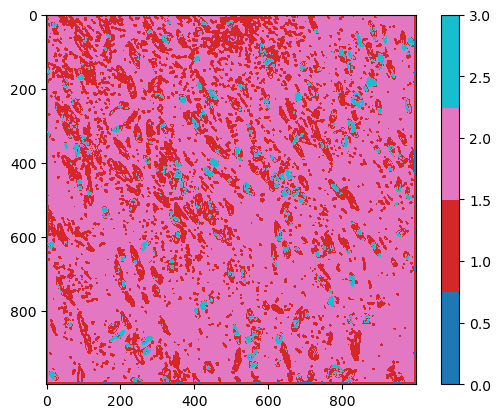

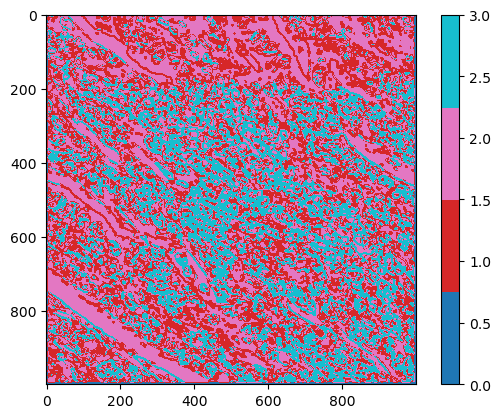

In [30]:
for image in image_p3:
    plot_image(image)

C:\Users\aydin\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


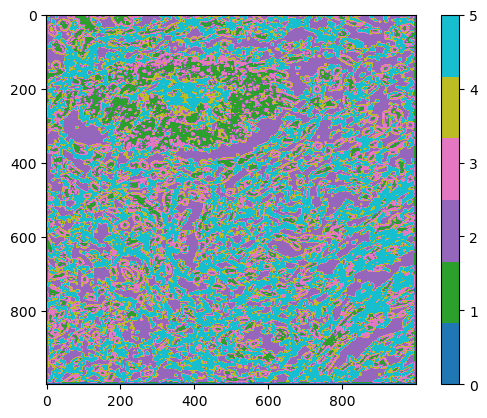

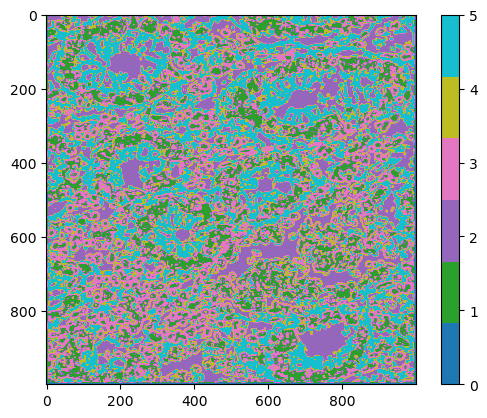

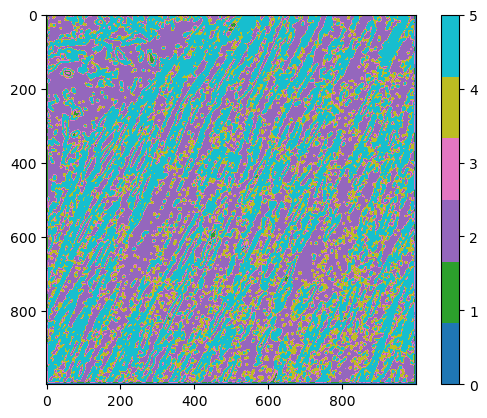

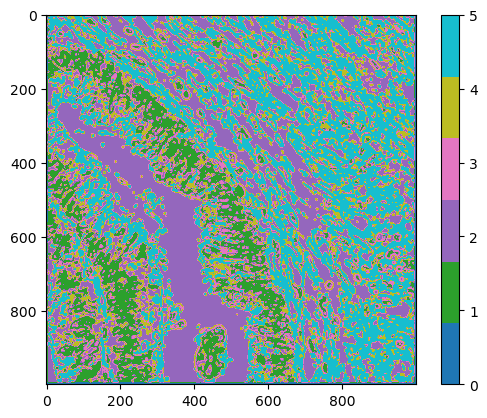

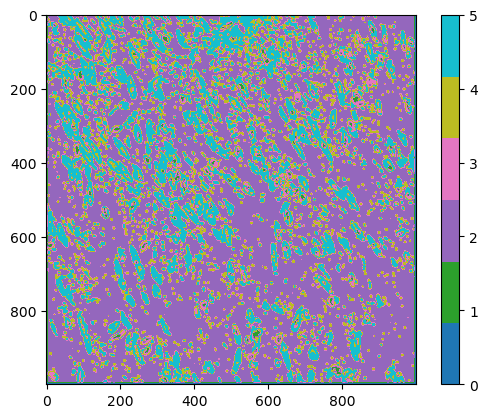

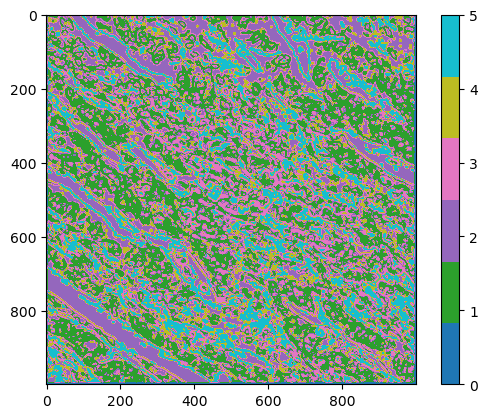

In [31]:
labels4 = cluster(features3, coordinates3, k=5)
labels4.shape
image_p6 = get_results(labels4, coordinates3, images)
for image in image_p6:
    plot_image(image)

In [32]:
def list_of_labels(data_label, image_):
    labeled_image = []
    for i in range(len(data_label)):
        labeled_image.append(data_label[i])
        
    list_label = []
    for im in range(6):
        image_labels = []
        for i in range(len(labeled_image[im])):
            x,y,label = labeled_image[im][i]
            image_labels.append((x,y,label,image_[im,x, y]))
        list_label.append(image_labels)
    return list_label

In [33]:
def count_labels(list_label):
    epithelial_count = 0
    spindle_count = 0
    inflammation_count = 0
    for i in range(6):
        for item in list_label[i]:
            if item[2] == 'epithelial':
                epithelial_count += 1
            elif item[2] == 'spindle':
                spindle_count += 1
            elif item[2] == 'inflammation':
                inflammation_count += 1
    print(epithelial_count)
    print(spindle_count)
    print(inflammation_count)
    return (epithelial_count, spindle_count, inflammation_count)

In [44]:
def interpretation(list_label):
    cluster1_epithelial = 0
    cluster1_spindle = 0
    cluster1_inflammation = 0
    cluster2_epithelial = 0
    cluster2_spindle = 0
    cluster2_inflammation = 0
    cluster3_epithelial = 0
    cluster3_spindle = 0
    cluster3_inflammation = 0

    for image in range(len(images)):
        for labeled in range(len(list_label[image])):
            if str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'epithelial':
                cluster1_epithelial+=1
            elif str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'spindle':
                cluster1_spindle+=1
            elif str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'inflammation':
                cluster1_inflammation+=1
            
            if str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'epithelial':
                cluster2_epithelial+=1
            elif str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'spindle':
                cluster2_spindle+=1
            elif str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'inflammation':
                cluster2_inflammation+=1
        
            if str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'epithelial':
                cluster3_epithelial+=1
            elif str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'spindle':
                cluster3_spindle+=1
            elif str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'inflammation':
                cluster3_inflammation+=1
        

    data = {
        'Cluster': [1, 2, 3],
        'Epithelial': [cluster1_epithelial/epithelial_count, cluster2_epithelial/epithelial_count, cluster3_epithelial/epithelial_count],
        'Spindle': [cluster1_spindle/spindle_count, cluster2_spindle/spindle_count, cluster3_spindle/spindle_count],
        'Inflammation': [cluster1_inflammation/inflammation_count, cluster2_inflammation/inflammation_count, cluster3_inflammation/inflammation_count]
    }

    df = pd.DataFrame(data)

    df.set_index('Cluster', inplace=True)

    print(df)

In [45]:
def interpretation2(list_label):
    cluster1_epithelial = 0
    cluster1_spindle = 0
    cluster1_inflammation = 0
    
    cluster2_epithelial = 0
    cluster2_spindle = 0
    cluster2_inflammation = 0
    
    cluster3_epithelial = 0
    cluster3_spindle = 0
    cluster3_inflammation = 0
    
    cluster4_epithelial = 0
    cluster4_spindle = 0
    cluster4_inflammation = 0
    
    cluster5_epithelial = 0
    cluster5_spindle = 0
    cluster5_inflammation = 0


    for image in range(len(images)):
        for labeled in range(len(list_label[image])):
            if str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'epithelial':
                cluster1_epithelial+=1
            elif str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'spindle':
                cluster1_spindle+=1
            elif str(list_label[image][labeled][3]) == '1.0' and list_label[image][labeled][2] == 'inflammation':
                cluster1_inflammation+=1
            
            if str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'epithelial':
                cluster2_epithelial+=1
            elif str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'spindle':
                cluster2_spindle+=1
            elif str(list_label[image][labeled][3]) == '2.0' and list_label[image][labeled][2] == 'inflammation':
                cluster2_inflammation+=1
        
            if str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'epithelial':
                cluster3_epithelial+=1
            elif str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'spindle':
                cluster3_spindle+=1
            elif str(list_label[image][labeled][3]) == '3.0' and list_label[image][labeled][2] == 'inflammation':
                cluster3_inflammation+=1
                
            if str(list_label[image][labeled][3]) == '4.0' and list_label[image][labeled][2] == 'epithelial':
                cluster4_epithelial+=1
            elif str(list_label[image][labeled][3]) == '4.0' and list_label[image][labeled][2] == 'spindle':
                cluster4_spindle+=1
            elif str(list_label[image][labeled][3]) == '4.0' and list_label[image][labeled][2] == 'inflammation':
                cluster4_inflammation+=1
                
            if str(list_label[image][labeled][3]) == '5.0' and list_label[image][labeled][2] == 'epithelial':
                cluster5_epithelial+=1
            elif str(list_label[image][labeled][3]) == '5.0' and list_label[image][labeled][2] == 'spindle':
                cluster5_spindle+=1
            elif str(list_label[image][labeled][3]) == '5.0' and list_label[image][labeled][2] == 'inflammation':
                cluster5_inflammation+=1
        

    data = {
        'Cluster': [1, 2, 3, 4, 5],
        'Epithelial': [cluster1_epithelial/epithelial_count, cluster2_epithelial/epithelial_count, cluster3_epithelial/epithelial_count, cluster4_epithelial/epithelial_count, cluster5_epithelial/epithelial_count],
        'Spindle': [cluster1_spindle/spindle_count, cluster2_spindle/spindle_count, cluster3_spindle/spindle_count, cluster4_spindle/spindle_count, cluster5_spindle/spindle_count],
        'Inflammation': [cluster1_inflammation/inflammation_count, cluster2_inflammation/inflammation_count, cluster3_inflammation/inflammation_count, cluster4_inflammation/inflammation_count, cluster5_inflammation/inflammation_count]
    }

    df = pd.DataFrame(data)

    df.set_index('Cluster', inplace=True)

    print(df)

In [46]:
import pandas as pd
labels_image_p = list_of_labels(data_label, image_p)
epithelial_count, spindle_count, inflammation_count = count_labels(labels_image_p)

interpretation(labels_image_p)

labels_image_p5 = list_of_labels(data_label, image_p5)
interpretation2(labels_image_p5)

labels_image_p3 = list_of_labels(data_label, image_p3)
interpretation(labels_image_p3)

labels_image_p6 = list_of_labels(data_label, image_p6)
interpretation2(labels_image_p6)

1122
1500
560
         Epithelial   Spindle  Inflammation
Cluster                                    
1          0.368984  0.342667      0.348214
2          0.224599  0.173333      0.255357
3          0.406417  0.484000      0.396429
         Epithelial   Spindle  Inflammation
Cluster                                    
1          0.335116  0.413333      0.333929
2          0.108734  0.098667      0.146429
3          0.160428  0.120667      0.160714
4          0.204991  0.172000      0.175000
5          0.190731  0.195333      0.183929
         Epithelial   Spindle  Inflammation
Cluster                                    
1          0.438503  0.384000      0.423214
2          0.302139  0.358667      0.278571
3          0.259358  0.257333      0.298214
         Epithelial   Spindle  Inflammation
Cluster                                    
1          0.218360  0.170667      0.225000
2          0.200535  0.268667      0.207143
3          0.134581  0.139333      0.176786
4          0.22370